<a href="https://colab.research.google.com/github/regs08/Notebooks/blob/main/TrainWithKaggleDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code adapted from:

https://github.com/bnsreenu/python_for_microscopists/blob/master/Tips_tricks_35_loading_kaggle_data_to_colab.ipynb

First we need to download the dataset. Skip these steps if you are uploading the data. Make sure GPU is enabled.

In [1]:
#install kaggle
!pip install kaggle --quiet


In [2]:
#run to mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#fill in paths. will need to get your own API key from kaggle 
import os

PATHS = {
    'API_KEY' : "/content/drive/MyDrive/APIKeys/kaggle.json",
    'DATASET' : "nicolaasregnier/pinotnoirgrapes"
    
}

DIRS = {
    #default is home directory,/content
    'DATA': "content/"
}

In [4]:
#making dir for kaggle
! mkdir ~/.kaggle

In [5]:
#copying our API key over
!cp {PATHS['API_KEY']} ~/.kaggle/kaggle.json


In [6]:
#giving permission to kaggle
!chmod 600 ~/.kaggle/kaggle.json


In [7]:
#downloading our dataset
!kaggle datasets download {PATHS['DATASET']}

 94% 193M/205M [00:02<00:00, 81.6MB/s]
100% 205M/205M [00:02<00:00, 101MB/s] 


In [8]:
#path to zipfile
PATHS['ZIP'] = os.path.join('/content', os.path.basename(PATHS['DATASET']) + '.zip')

In [ ]:
#unzipping
#unzips a copy in content and a copy in drive. should look into this...
!unzip {PATHS['ZIP']}

**Now we start training**

In [22]:
# Sometimes get the error NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968
#run the following 
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [23]:
#getting our YOLO library
!pip install ultralytics --quiet
!pip install supervision --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 1.9 MB/s eta 0:00:00


In [24]:
from ultralytics import YOLO
import supervision as sv
import cv2

In [12]:
import os 
#where our train/val/test folders reside
data_dir = "/content/grape_clusters/SpltImagesTrain"
model_name = 'single_box_grape'
DIRS = {
    'DATA' :  data_dir,
    #the call to model.train will create a folder with the given model name
    'MODEL_SAVE': os.path.join(data_dir, model_name ),
}

PATHS = {
    'YAML' : os.path.join(DIRS['DATA'], 'data.yaml'),
    #pretrained weights or ../path/to/trained/model.pt
    'MODEL' : 'yolov8m.pt',
    'TEST_IMAGE': "/content/grape_clusters/SpltImagesTrain/test/images/IMG_0230_1.JPG",
}

In [13]:
#training
model = YOLO(PATHS['MODEL'])
model.train(data=PATHS['YAML'], epochs=35, name=DIRS['MODEL_SAVE'], patience=10)  

100%|██████████| 49.7M/49.7M [00:00<00:00, 166MB/s]
Ultralytics YOLOv8.0.109 🚀 Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/grape_clusters/SpltImagesTrain/data.yaml, epochs=35, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=/content/grape_clusters/SpltImagesTrain/single_box_grape, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, re

In [17]:
#docs for predict function
#https://docs.ultralytics.com/modes/predict/#arguments
#saves to {DIRS[MODEL_SAVE]} or to ~/runs/detect/predict2
result = model.predict(source=PATHS['TEST_IMAGE'], save=True, conf=.25, iou=.25)


image 1/1 /content/grape_clusters/SpltImagesTrain/test/images/IMG_0230_1.JPG: 480x640 10 grapes, 50.1ms
Speed: 13.9ms preprocess, 50.1ms inference, 32.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/grape_clusters/SpltImagesTrain/single_box_grape4


In [25]:
#loading image as array
#load a custom img from the testset
img_path = "path/to/image"
#or

img = cv2.imread(PATHS['TEST_IMAGE'])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#we put our result in our detection class
detections = sv.Detections.from_yolov8(result[0])

#bbox format for plotting
box_annotator = sv.BoxAnnotator(
        thickness=2,
        text_thickness=1,
        text_scale=0.5
    )

#extracting label info
labels = [f"{model.model.names[class_id]} {conf:0.2f}" for _,_, conf, class_id,_ in detections]

#adding the label info and boxes to the img
pred = box_annotator.annotate(
    scene=img, 
    detections=detections,
    labels=labels
)

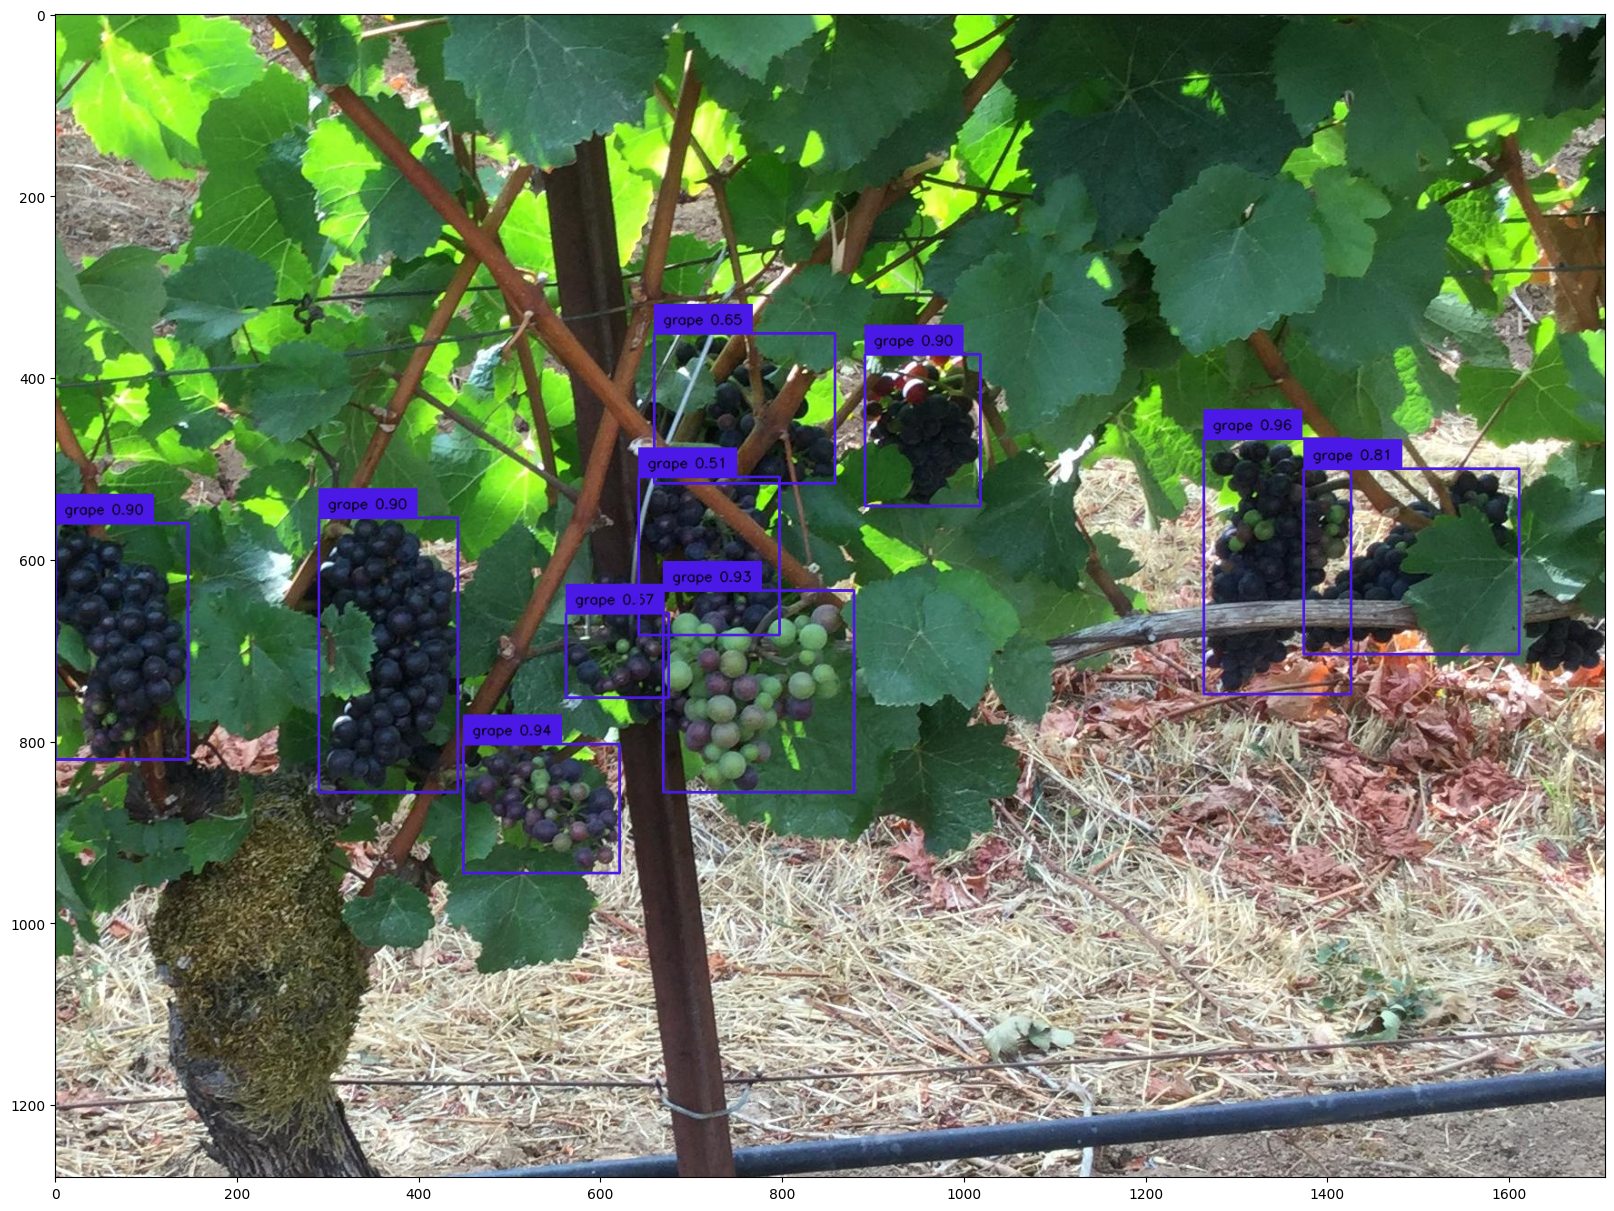

In [26]:
from matplotlib import pyplot as plt
#plotting our pred
plt.figure(figsize = (20,20))
plt.imshow(pred)